In [3]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

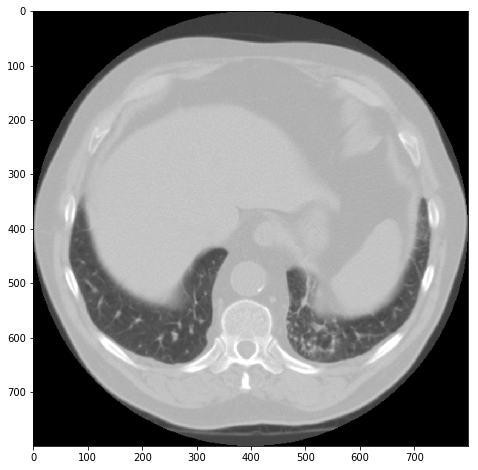

In [18]:
# name = 'im1.png'
# name = 'im2.png'
# name = 'im3.png'
# name = 'im4.png'
# name = 'im5.png'
# name = 'im6.png'
# name = 'im7.png'
# name = 'im8.png'
# name = 'im9.png'
name = 'im10.png'
# name = 'im11.png'
# name = 'im12.png'
# name = 'im13.png'
# name = 'im14.png'
# name = 'im15.png'
# name = 'im16.png'
# name = 'im17.png'
# name = 'im18.png'
# name = 'im19.png'
# name = 'im20.png'

image_name = 'dataset/'+name
img = cv2.imread(image_name)[:,:,0]
plt.figure(figsize=(10,8))
plt.imshow(img, cmap='gray')
plt.show()

**Cambio el fondo negro por un gris de la imagen para que se clasifique como la misma región**

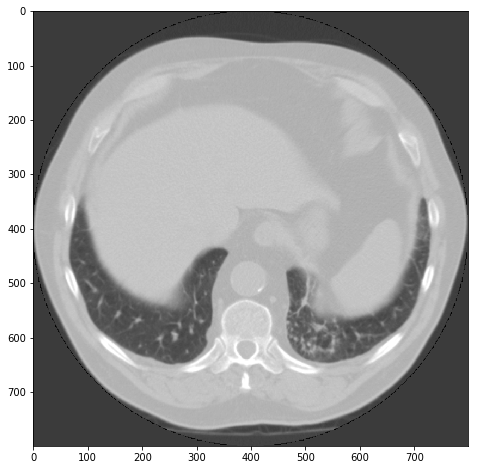

In [23]:
hist, _ = np.histogram(img, 256, [0, 256])
gray = np.argmax(hist[1:]>500) + 1
row,col = img.shape
img = img.flatten()
img[img == 0] = gray
img = img.reshape((row,col))
plt.figure(figsize=(10,8))
plt.imshow(img, cmap='gray')
plt.show()

**Aplico k-means para segmentar en regiones**

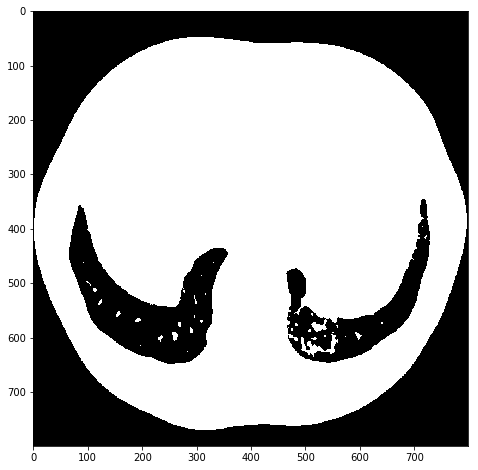

In [24]:
# blur = cv2.GaussianBlur(img,(21,21),0)
Z = np.float32(img.reshape((-1,1)))
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
dist,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center) # Convertir los float a uint8
# A partir del array de etiquetas, generar un array en el cada posición es el centro de clúster
# correspondiente a dicha etiqueta
res = center[label.flatten()]
# Redimensionar el array plano a una imagen bidimensional
res2 = res.reshape((img.shape)) 
normal = (res2 - np.min(res2)) / (np.max(res2) - np.min(res2)).astype(int)
plt.figure(figsize=(10,8))
plt.imshow(normal, cmap='gray')
plt.show()

**Añado márgenes a la imagen para que no se pegue a los límites**

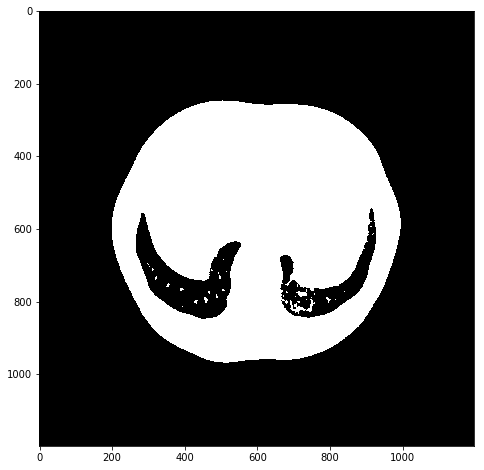

In [25]:
newimage = np.zeros((int(normal.shape[0]*1.5), int(normal.shape[0]*1.5)))
newimage[int(normal.shape[0]*0.25):int(normal.shape[0]*1.25), int(normal.shape[1]*0.25):int(normal.shape[1]*1.25)] = normal
plt.figure(figsize=(10,8))
plt.imshow(newimage, cmap='gray')
plt.show()

**Obtengo la región blanca más grande, que será el tronco de la persona**

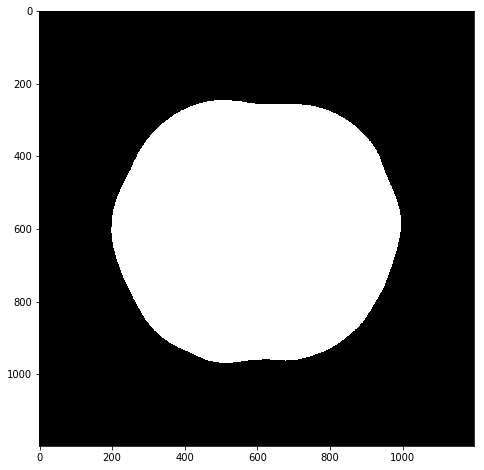

In [26]:
_, contours, hierarchy = cv2.findContours(newimage.astype(int),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
mask = np.zeros(newimage.shape,np.uint8)
best_cnt = contours[0]
max_a = 0
for cnt in contours:
    a = cv2.contourArea(cnt)
    if a > max_a:
        max_a = a
        best_cnt = cnt
cv2.drawContours(mask,[best_cnt],-1,(1,1,1),-1)
plt.figure(figsize=(10,8))
plt.imshow(mask, cmap='gray')
plt.show()

**Vuelvo al tamaño original**

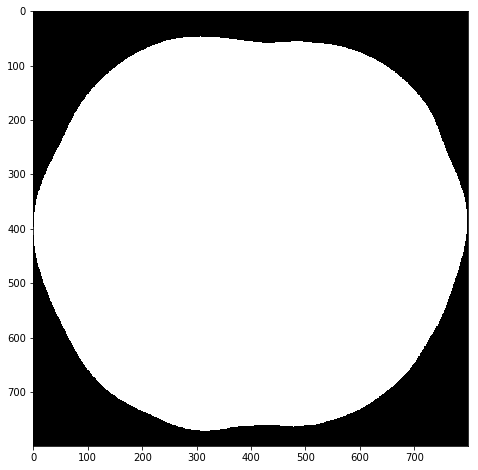

In [27]:
orig_size = np.zeros(normal.shape)
orig_size = mask[int(normal.shape[0]*0.25):int(normal.shape[0]*1.25), int(normal.shape[1]*0.25):int(normal.shape[1]*1.25)]
mask = orig_size
plt.figure(figsize=(10,8))
plt.imshow(mask, cmap='gray')
plt.show()

**Aplico la máscara y la invierto para quedarme con los posibles pulmones**

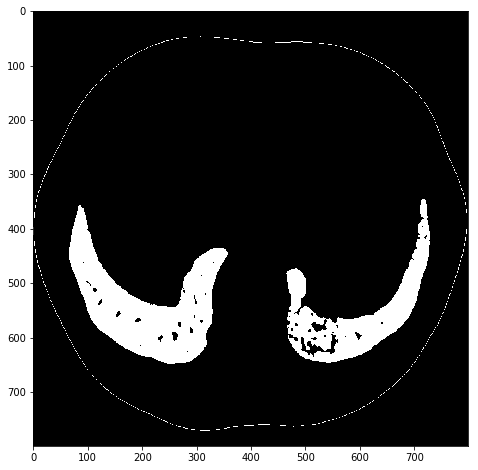

In [28]:
masked = 1 - (normal * mask - mask)
plt.figure(figsize=(10,8))
plt.imshow(masked, cmap='gray')
plt.show()

**Realizo una apertura para eliminar el borde artificial**

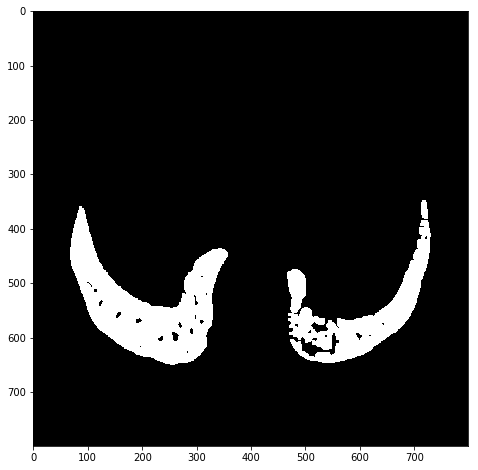

In [31]:
kernel = np.ones((6,6), np.uint8)
opening = cv2.morphologyEx(masked, cv2.MORPH_OPEN, kernel)
plt.figure(figsize=(10,8))
plt.imshow(opening,cmap='gray')
plt.show()

**Separo las dos mayores regiones para que no se fusionen**

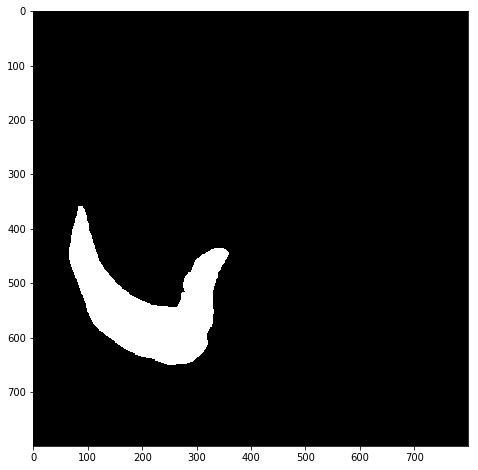

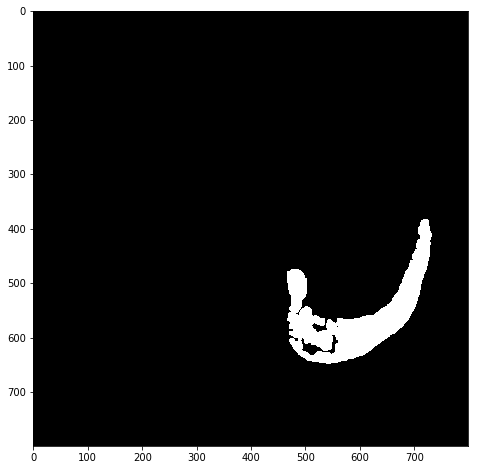

In [32]:
_, contours, hierarchy = cv2.findContours((1-opening).astype(int),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
contours.sort(key=cv2.contourArea, reverse=True)
mask1 = np.zeros(opening.shape,np.uint8)
mask2 = np.zeros(opening.shape,np.uint8)
cv2.drawContours(mask1,[contours[0]],-1,(1,1,1), thickness=cv2.FILLED)
cv2.drawContours(mask2,[contours[1]],-1,(1,1,1), thickness=cv2.FILLED)
# cv2.fillPoly(mask, pts=contours[0], color=(255,255,255))
plt.figure(figsize=(10,8))
plt.imshow(mask1, cmap='gray')
plt.show()
plt.figure(figsize=(10,8))
plt.imshow(mask2, cmap='gray')
plt.show()

**Aplico un gran cierre a cada una para incluir posibles tumores pegados al borde**

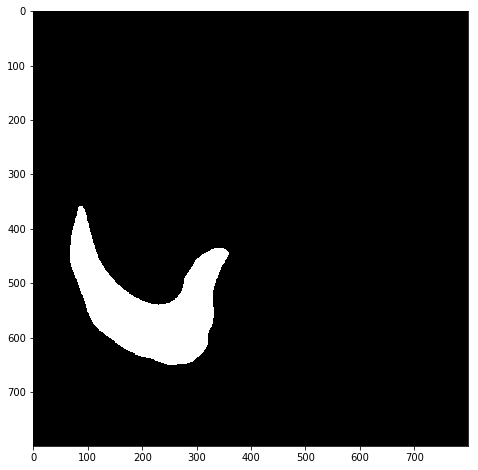

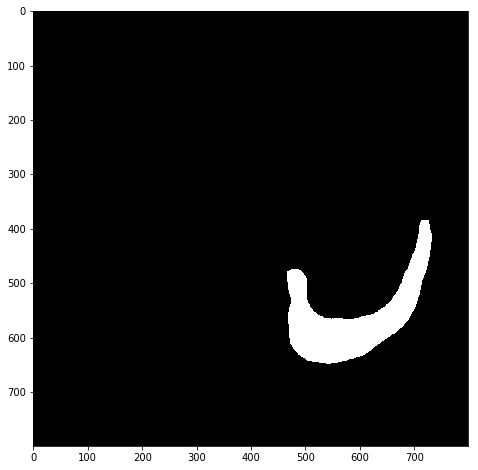

In [33]:
newimage1 = np.zeros((int(normal.shape[0]*1.5), int(normal.shape[0]*1.5)))
newimage1[int(normal.shape[0]*0.25):int(normal.shape[0]*1.25), int(normal.shape[1]*0.25):int(normal.shape[1]*1.25)] = mask1
newimage2 = np.zeros((int(normal.shape[0]*1.5), int(normal.shape[0]*1.5)))
newimage2[int(normal.shape[0]*0.25):int(normal.shape[0]*1.25), int(normal.shape[1]*0.25):int(normal.shape[1]*1.25)] = mask2
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(90,90))
closing1 = cv2.morphologyEx(newimage1, cv2.MORPH_CLOSE, kernel)
closing2 = cv2.morphologyEx(newimage2, cv2.MORPH_CLOSE, kernel)
orig_size1 = np.zeros(normal.shape)
orig_size1 = closing1[int(normal.shape[0]*0.25):int(normal.shape[0]*1.25), int(normal.shape[1]*0.25):int(normal.shape[1]*1.25)]
orig_size2 = np.zeros(normal.shape)
orig_size2 = closing2[int(normal.shape[0]*0.25):int(normal.shape[0]*1.25), int(normal.shape[1]*0.25):int(normal.shape[1]*1.25)]
closing1 = orig_size1
closing2 = orig_size2
plt.figure(figsize=(10,8))
plt.imshow(closing1,cmap='gray')
plt.show()
plt.figure(figsize=(10,8))
plt.imshow(closing2,cmap='gray')
plt.show()

**Aplico la máscara final a la imagen original y obtengo los pulmones segmentados**

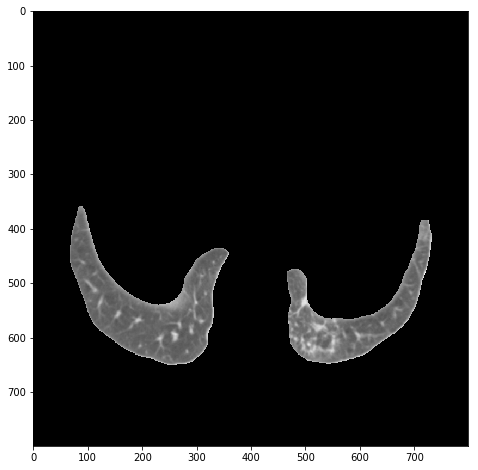

In [34]:
plt.figure(figsize=(10,8))
plt.imshow(img * ((closing1)+(closing2)), cmap='gray')
plt.show()

**Fallos:**  
- problema con zona "nubosa" en im9 e im11
- se pierde parte de pulmón en im5 e im6

------------------------------------------------------------------

dataset/im1.png


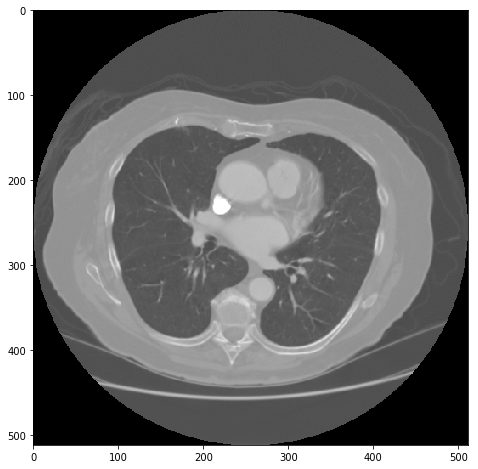

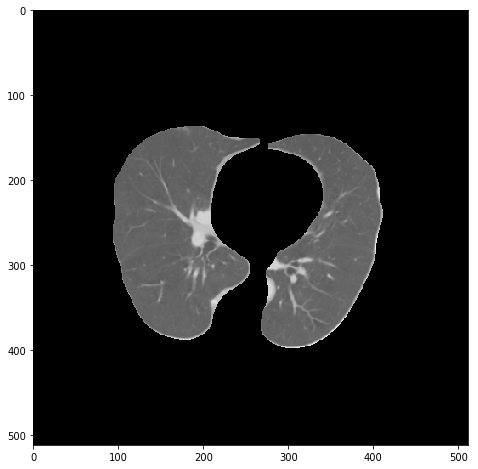

dataset/im2.png


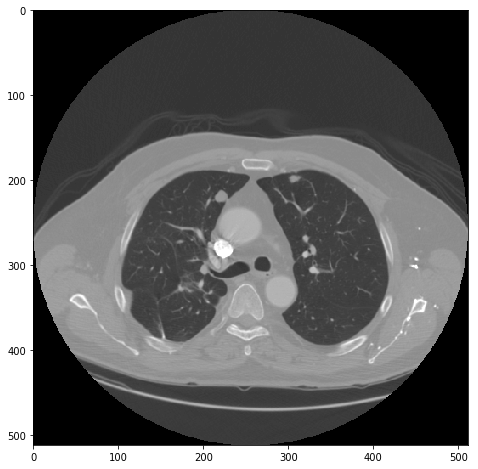

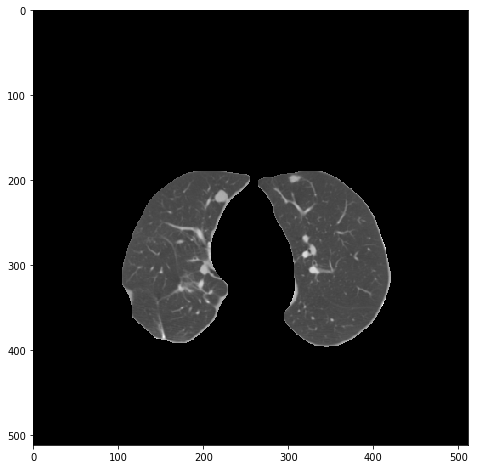

dataset/im3.png


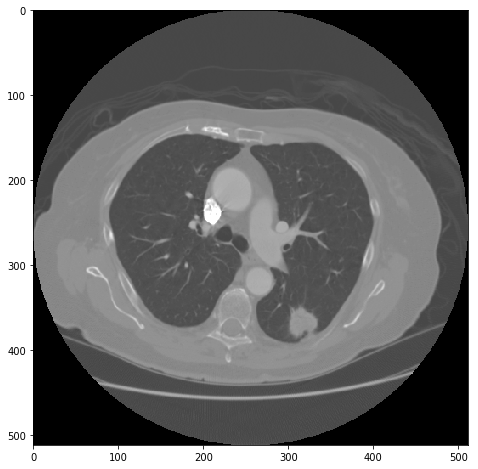

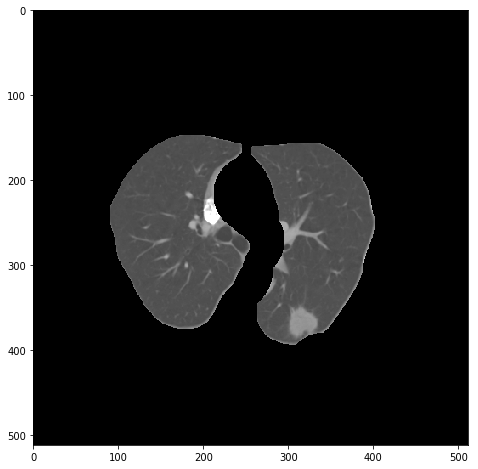

dataset/im4.png


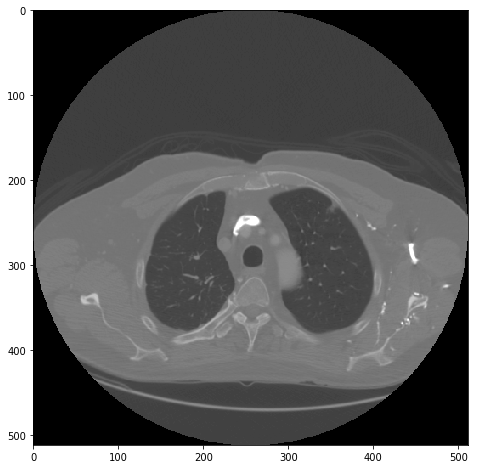

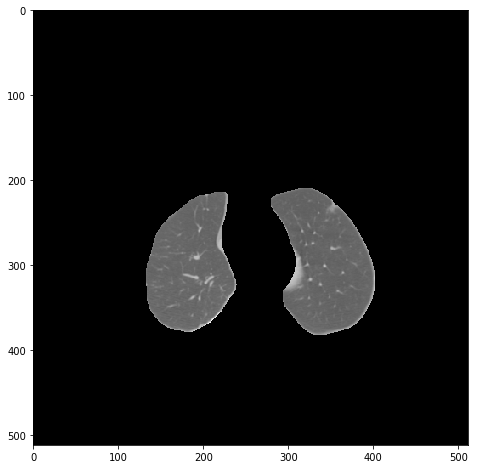

dataset/im5.png


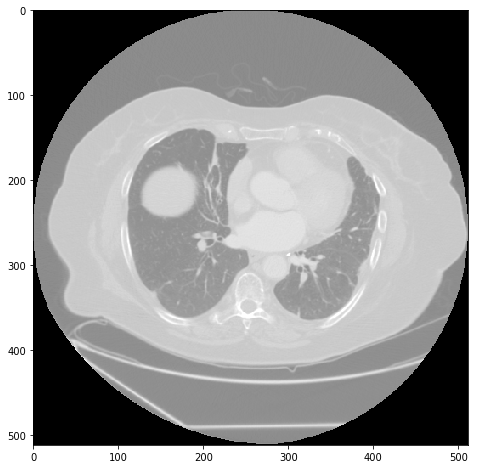

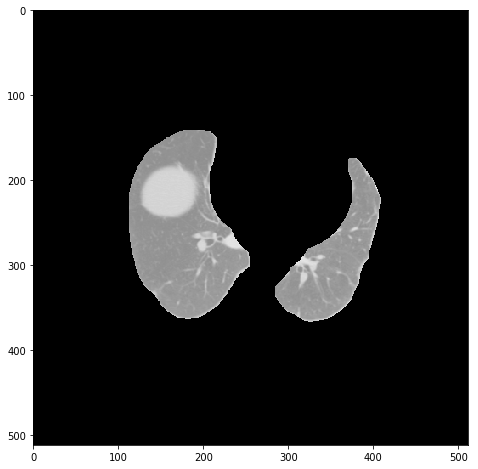

dataset/im6.png


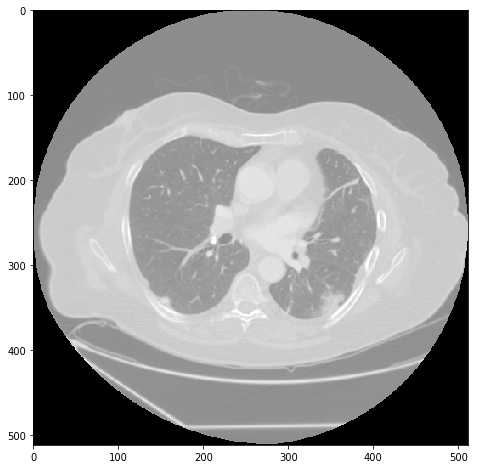

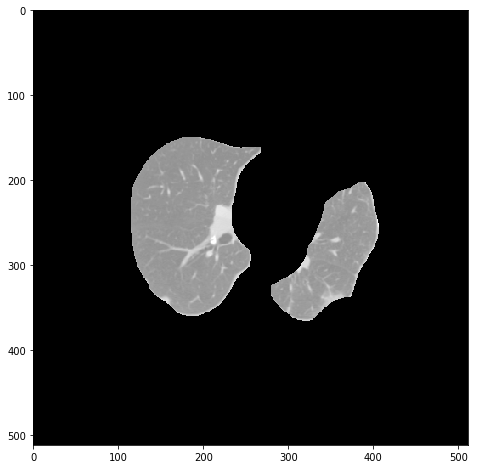

dataset/im7.png


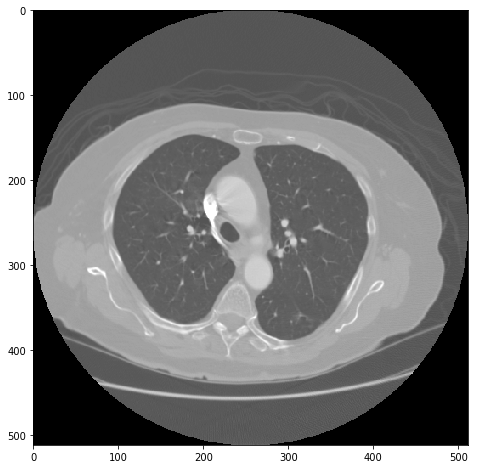

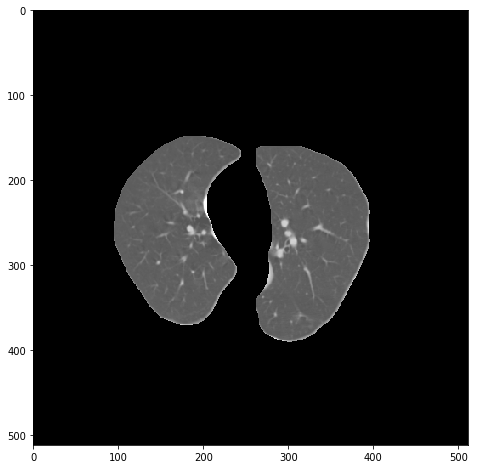

dataset/im8.png


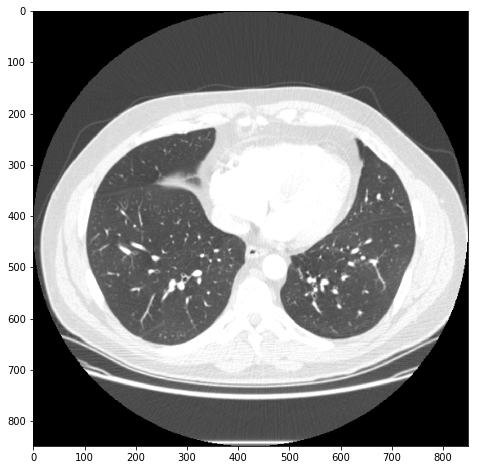

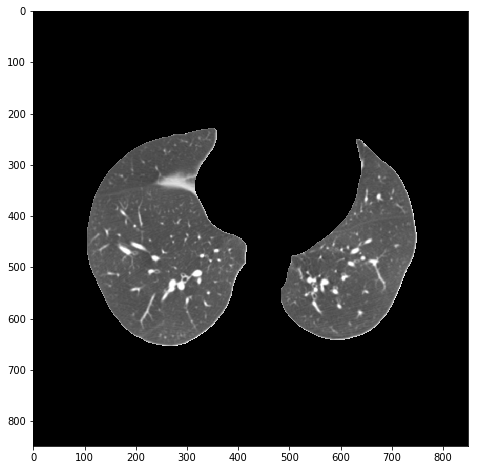

dataset/im9.png


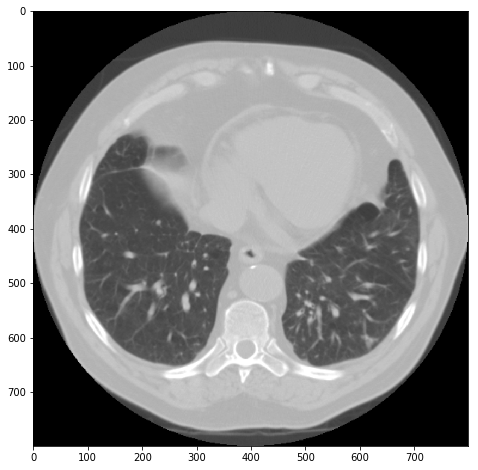

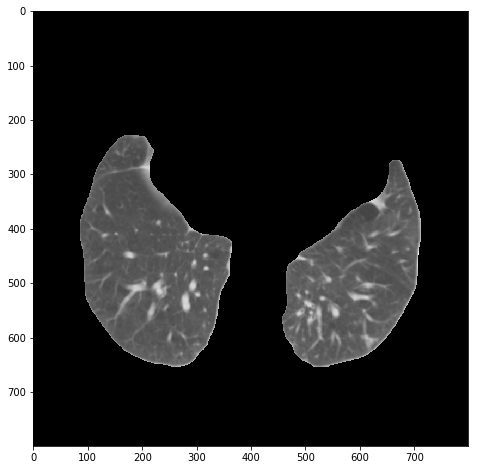

dataset/im10.png


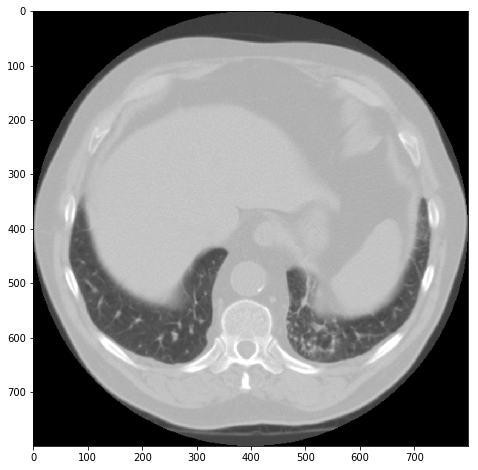

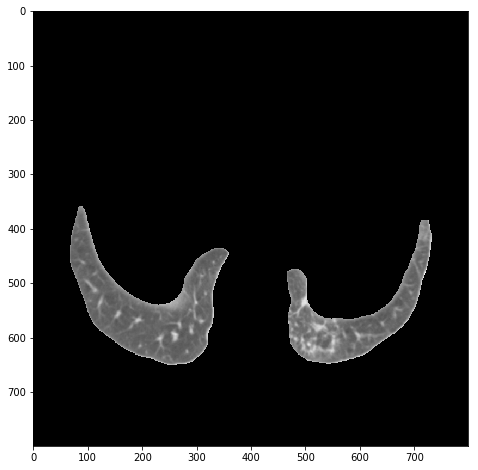

dataset/im11.png


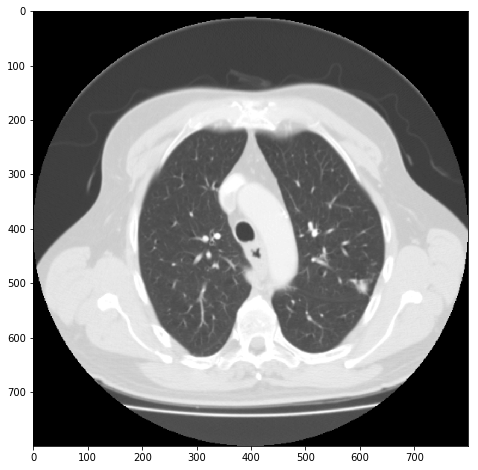

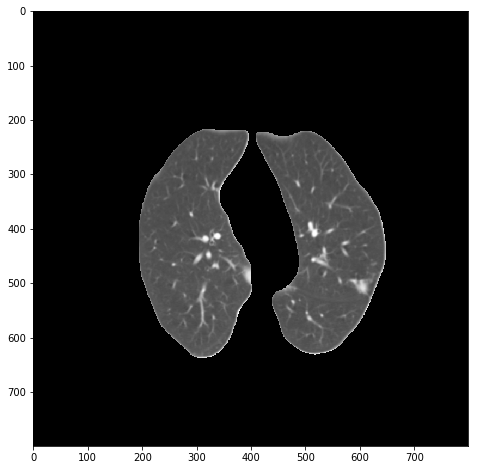

dataset/im12.png


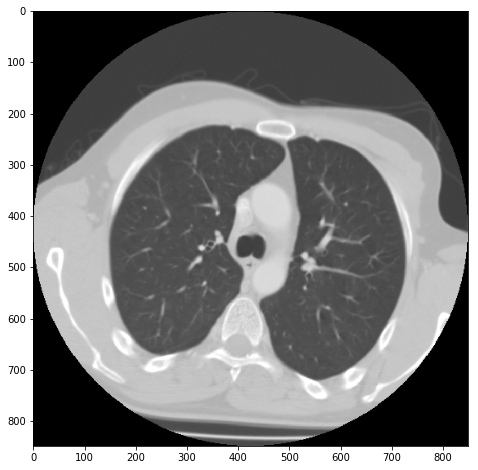

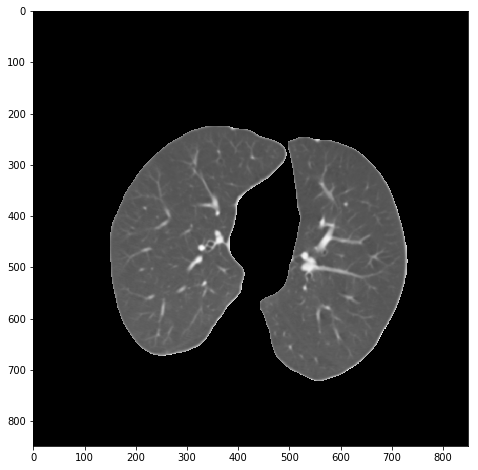

dataset/im13.png


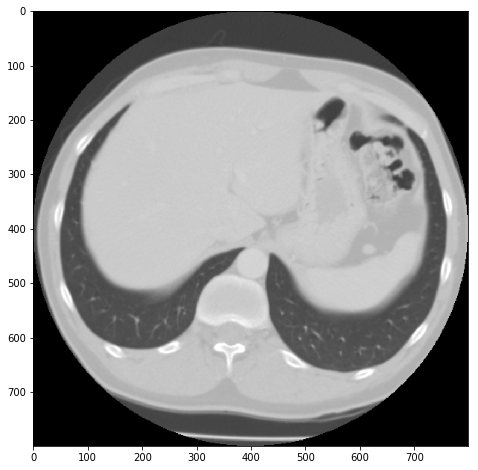

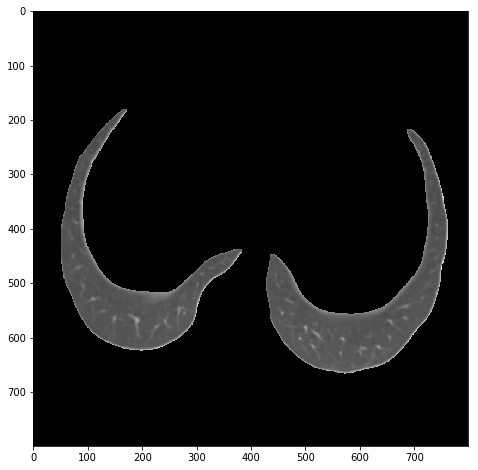

dataset/im14.png


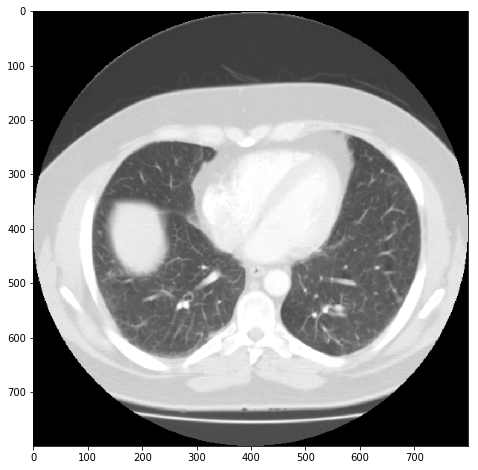

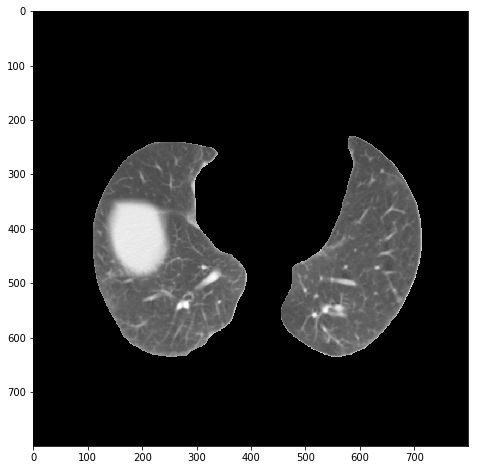

dataset/im15.png


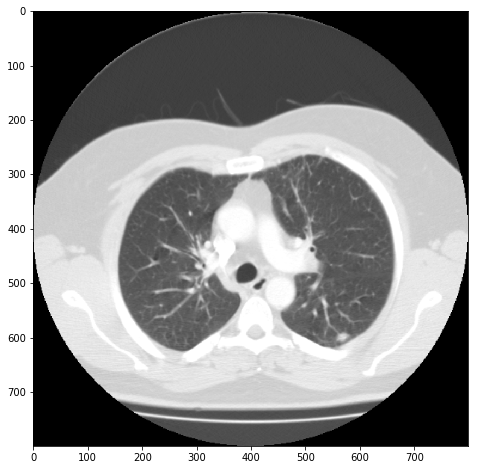

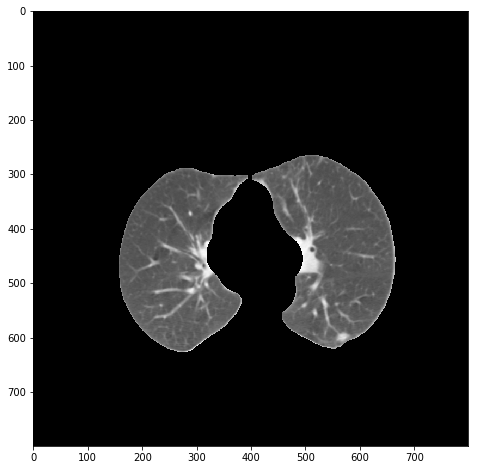

dataset/im16.png


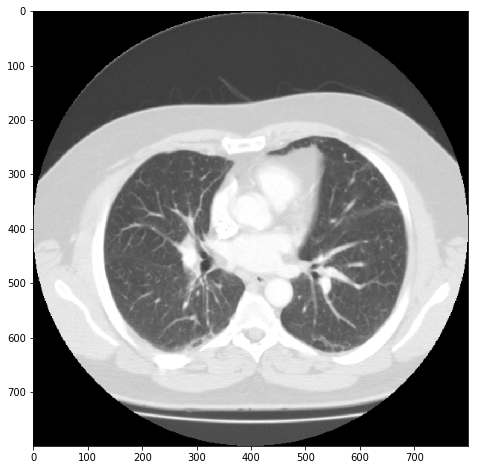

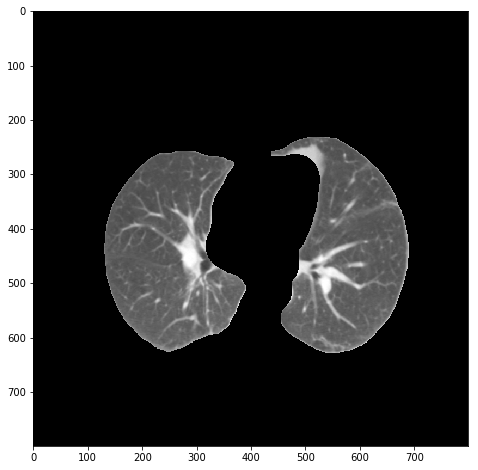

dataset/im17.png


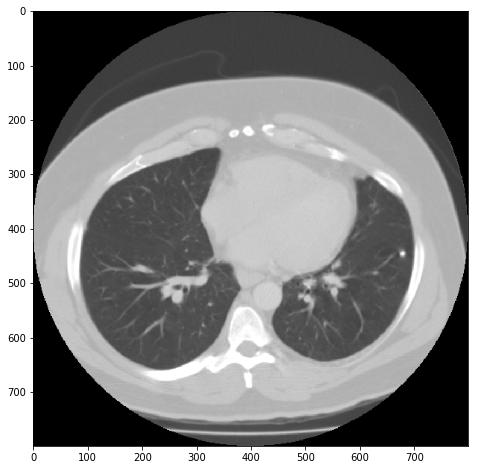

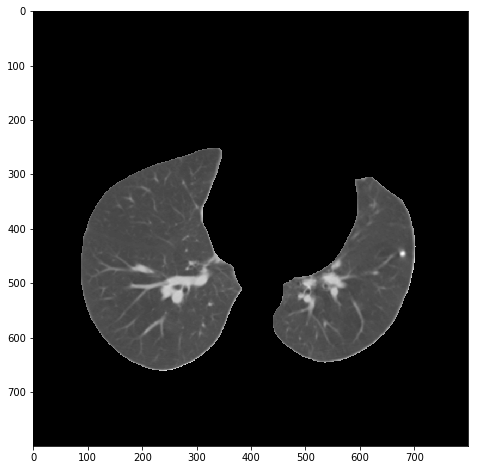

dataset/im18.png


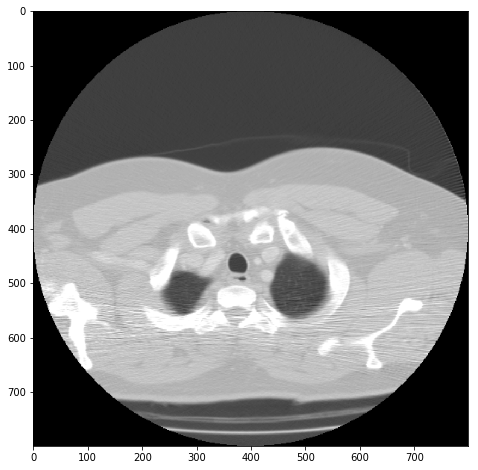

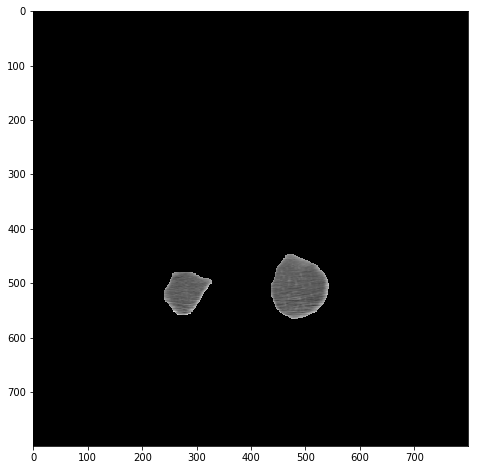

dataset/im19.png


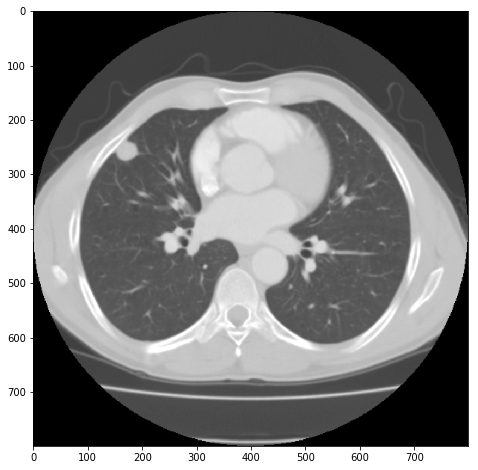

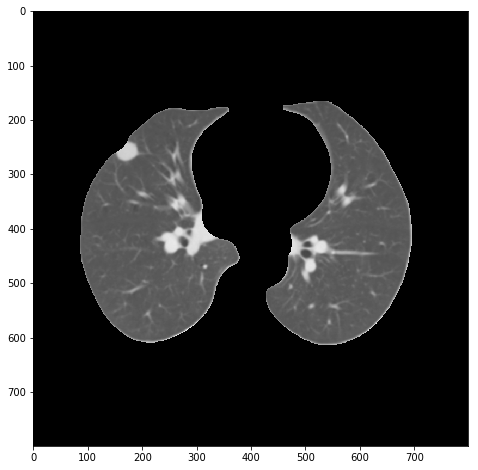

dataset/im20.png


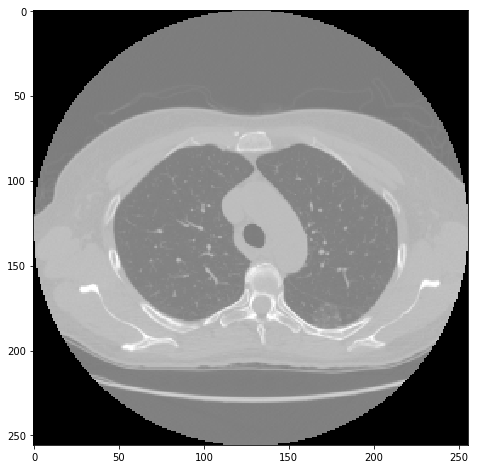

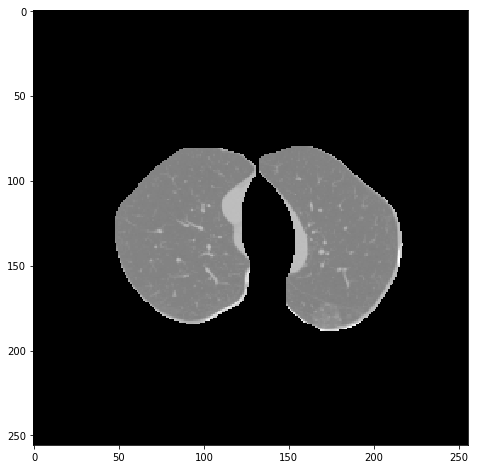

In [38]:
name_list = ['im1.png', 'im2.png', 'im3.png', 'im4.png', 'im5.png', 'im6.png', 'im7.png', 'im8.png', 'im9.png', 'im10.png', 'im11.png', 'im12.png', 'im13.png', 'im14.png', 'im15.png', 'im16.png', 'im17.png', 'im18.png', 'im19.png', 'im20.png']
save_fig = True
for n, name in enumerate(name_list):
    image_name = 'dataset/'+name
    img = cv2.imread(image_name)[:,:,0]
    
    print(image_name)
    plt.figure(figsize=(10,8))
    plt.imshow(img, cmap='gray')
    plt.show()
    
    hist, _ = np.histogram(img, 256, [0, 256])
    gray = np.argmax(hist[1:]>500) + 1
    row,col = img.shape
    img = img.flatten()
    img[img == 0] = gray
    img = img.reshape((row,col))

    Z = np.float32(img.reshape((-1,1)))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    dist,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center) # Convertir los float a uint8
    # A partir del array de etiquetas, generar un array en el cada posición es el centro de clúster
    # correspondiente a dicha etiqueta
    res = center[label.flatten()]
    # Redimensionar el array plano a una imagen bidimensional
    res2 = res.reshape((img.shape)) 

    normal = (res2 - np.min(res2)) / (np.max(res2) - np.min(res2)).astype(int)

    newimage = np.zeros((int(normal.shape[0]*1.5), int(normal.shape[0]*1.5)))
    newimage[int(normal.shape[0]*0.25):int(normal.shape[0]*1.25), int(normal.shape[1]*0.25):int(normal.shape[1]*1.25)] = normal

    _, contours, hierarchy = cv2.findContours(newimage.astype(int),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
    mask = np.zeros(newimage.shape,np.uint8)
    best_cnt = contours[0]
    max_a = 0
    for cnt in contours:
        a = cv2.contourArea(cnt)
        if a > max_a:
            max_a = a
            best_cnt = cnt
    cv2.drawContours(mask,[best_cnt],-1,(1,1,1),-1)

    orig_size = np.zeros(normal.shape)
    orig_size = mask[int(normal.shape[0]*0.25):int(normal.shape[0]*1.25), int(normal.shape[1]*0.25):int(normal.shape[1]*1.25)]
    mask = orig_size

    masked = 1 - (normal * (mask) - mask)

    kernel = np.ones((6,6), np.uint8)
    opening = cv2.morphologyEx(masked, cv2.MORPH_OPEN, kernel)

    _, contours, hierarchy = cv2.findContours((1-opening).astype(int),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
    contours.sort(key=cv2.contourArea, reverse=True)
    mask1 = np.zeros(opening.shape,np.uint8)
    mask2 = np.zeros(opening.shape,np.uint8)
    cv2.drawContours(mask1,[contours[0]],-1,(1,1,1), thickness=cv2.FILLED)
    cv2.drawContours(mask2,[contours[1]],-1,(1,1,1), thickness=cv2.FILLED)

    newimage1 = np.zeros((int(normal.shape[0]*1.5), int(normal.shape[0]*1.5)))
    newimage1[int(normal.shape[0]*0.25):int(normal.shape[0]*1.25), int(normal.shape[1]*0.25):int(normal.shape[1]*1.25)] = mask1
    newimage2 = np.zeros((int(normal.shape[0]*1.5), int(normal.shape[0]*1.5)))
    newimage2[int(normal.shape[0]*0.25):int(normal.shape[0]*1.25), int(normal.shape[1]*0.25):int(normal.shape[1]*1.25)] = mask2
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(90,90))
    closing1 = cv2.morphologyEx(newimage1, cv2.MORPH_CLOSE, kernel)
    closing2 = cv2.morphologyEx(newimage2, cv2.MORPH_CLOSE, kernel)
    orig_size1 = np.zeros(normal.shape)
    orig_size1 = closing1[int(normal.shape[0]*0.25):int(normal.shape[0]*1.25), int(normal.shape[1]*0.25):int(normal.shape[1]*1.25)]
    orig_size2 = np.zeros(normal.shape)
    orig_size2 = closing2[int(normal.shape[0]*0.25):int(normal.shape[0]*1.25), int(normal.shape[1]*0.25):int(normal.shape[1]*1.25)]
    closing1 = orig_size1
    closing2 = orig_size2

    plt.figure(figsize=(10,8))
    plt.imshow(img * ((closing1)+(closing2)), cmap='gray')
    if save_fig:
        plt.savefig(name)
    plt.show()